In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# generate spike trains that slowly increase in rate

# 30 minutes of data
# from 1 Hz to 10 Hz
# add sinusoidal noises

def gen_spike():
    np.random.seed(0)
    sample_rate = 25000
    n_time = 30
    times = np.arange(n_time)

    rates = np.linspace(1, 10, n_time) + 0.5 * np.sin(2 * np.pi * 0.05 * times) + 2*np.random.normal(0, 0.5, n_time)
    rates = np.repeat(rates, sample_rate * 60)
    spikes = np.random.poisson(rates / sample_rate)

    spk = np.where(spikes)[0] / sample_rate
    return spk

spk = gen_spike()

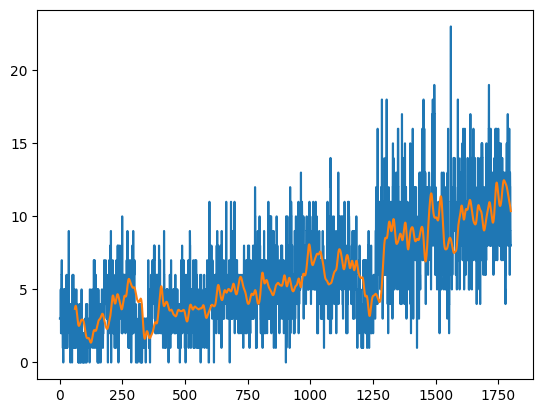

In [48]:
from scipy import signal

monitor_duration = 1800 # seconds
window_size = 60 # seconds
window_step = 0.1 # seconds
n_window = 10

time_end = spk[-1]
time_start = max(spk[0], time_end - monitor_duration)
time_bin = np.arange(time_end, time_start, -window_step)[::-1]

conv_win = np.ones(n_window)

spk_bin, _ = np.histogram(spk.astype(int), time_bin)
spk_bin = np.convolve(spk_bin, conv_win, mode='valid')
# match the length of time_bin with spk_bin
n_spk_bin = len(spk_bin)
time_bin = time_bin[-n_spk_bin:]


gaussian_win = signal.gaussian(600, std=50)
gaussian_win /= gaussian_win.sum()
spk_cov = signal.convolve(spk_bin, gaussian_win, mode='valid')
time_conv = time_bin[-len(spk_cov):]

plt.plot(time_bin, spk_bin)
plt.plot(time_conv, spk_cov)

In [53]:
fire_rate = 1/3 # Hz
n_step = int(window_size//window_step)
n_fire = int(window_size * fire_rate)

tresholds = []
# for i in range(1):
# Vectorize operations and avoid repeated calculations
spk_bins_padded = np.array([np.pad(spk_bin[i:i+n_step], (1, 1), mode='constant', constant_values=0) 
                           for i in range(n_spk_bin - n_step)])

thresholds = np.ones(n_spk_bin - n_step)
for i in range(n_spk_bin - n_step):
    threshold = 1
    spk_bin_i = spk_bins_padded[i]
    while True:
        over_threshold = (spk_bin_i >= threshold)
        # Find transitions using boolean operations instead of diff
        block_start = np.where(~over_threshold[:-1] & over_threshold[1:])[0]
        block_end = np.where(over_threshold[:-1] & ~over_threshold[1:])[0]
        
        if len(block_start) == 0 or len(block_end) == 0:
            break
            
        block_length = np.ceil((block_end - block_start) / n_window)
        
        if block_length.sum() >= n_fire:
            threshold += 1
        else:
            break
            
    tresholds.append(threshold - 1)

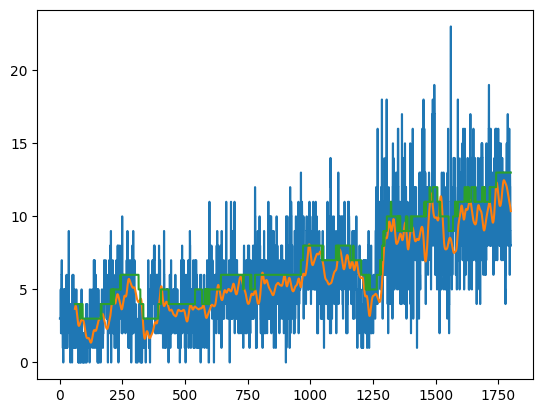

In [54]:
time_threshold = time_bin[-len(tresholds):]
plt.plot(time_bin, spk_bin)
plt.plot(time_conv, spk_cov)
plt.plot(time_threshold, tresholds)

In [26]:
spk[-1], time_bin[-1]

(1799.82372, 1800.10844)